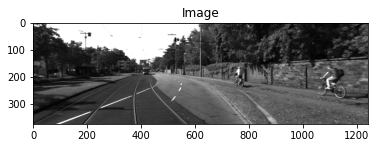

In [4]:
import cv2
import pykitti
import numpy as np
from matplotlib import pyplot as plt

kitty_dir = 'kitti/drives'
kitty_date = '2011_09_26'
kitty_drive = '0002'

data = pykitti.raw(kitty_dir, kitty_date, kitty_drive, frames=range(0, 5))

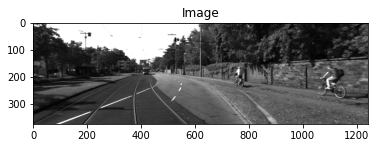

In [6]:
img1, img2 = data.get_gray(0)

img_np = np.array(img1)
plt.imshow(img_np, cmap='gray')
plt.title('Image')
plt.show()

## Detect Features

In [ ]:
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1)
kp2, des2 = orb.detectAndCompute(img2)